In [ ]:
pip install spacy

In [ ]:
!pip3 install nltk

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 6.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.0-py2.py3-none-any.whl size=136694 sha256=7262ade5a3111721d5df0816b0b3f39bd264e3eefa104a7022db051d258535b7
  Stored in directory: /root/.cache/pip/wheels/5e/62/9d/e2d11b7e09f85508b7be451fa35a2bce4b12c66c10b8bcb182
Successfully built pyLDAvis


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import timeit
from time import time


In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pyLDAvis
import pyLDAvis.gensim 


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from collections import Counter
from wordcloud import WordCloud

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_folder = '/content/drive/My Drive/IITR Project'
data_folder = '/content/drive/My Drive/IITR Project/data'

Mounted at /content/drive


In [ ]:
df_news=pd.read_csv(os.path.join(data_folder,'RedditNews-1.csv'))
df_news.head()


,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


#Topic Modeling of news from df_news

Data Preprocessing - Removing hyphen

In [ ]:
df_news = df_news.replace(np.nan, ' ', regex=True)
df_news = df_news.replace('b\"|b\'|\\\\|\\\"', '', regex=True)

TOKENISATION

Using Spacy Lemmatizer

In [ ]:
testdata = df_news['News']
#testdataNews = df_news['News']
#testdata = testdataNews[:100]

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
from spacy.lang.en import English
parser = English()

In [ ]:
stop_words=spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
print(stop_words)
len(stop_words)

{'due', 'is', 'using', 'n’t', 'doing', 'empty', 'herein', 'never', 'wherever', 'few', 'therein', 'besides', 'down', 'former', 'himself', 'ours', 'ourselves', 'six', 'these', 'throughout', 'whoever', 'by', 'meanwhile', '’ve', 'be', 'beyond', 'either', 'own', 'except', 'someone', 'what', 'four', 'along', 'hundred', 'via', 'namely', 'the', 'how', 'cannot', 'for', 'thereby', 'next', 'put', 'sometimes', 'under', 'from', 'it', 'each', 'keep', 'again', 'but', 'might', 'no', 'one', 'thus', 'which', '’d', 'most', 'although', 'am', "n't", "'ll", 'therefore', 'twenty', 'else', 'there', 'whole', 'does', 'has', 'say', 'above', 'onto', 'thru', 'mine', 'they', 'why', 'because', 'eight', 'fifty', 'see', 'nowhere', 'whither', 'already', 'whom', 'was', 'where', 'name', 'would', 'around', '‘s', 'used', 'any', 'go', 'moreover', 'other', 'me', 'something', 'whereby', 'his', 'within', 'rather', 'anyhow', 'enough', 'until', 'herself', 'neither', '’s', 'noone', 'whatever', 'ca', 'beforehand', 'could', 'thereu

326

In [ ]:
def spacy_lemma_text(text):
    token = []
    doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop_words]
    tokens = [tok for tok in tokens if len(tok) >= 3]
    #tokens = ' '.join(tokens)
    return tokens

filtered_words_text = testdata.apply(spacy_lemma_text)

In [ ]:
def join_tokens_text(text):
    token = []
    doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop_words]
    tokens = [tok for tok in tokens if len(tok) >= 3]
    tokens = ' '.join(tokens)
    return tokens

filtered_join_text = testdata.apply(join_tokens_text)

In [ ]:
filtered_words = filtered_words_text.to_list()

In [ ]:
id2word = corpora.Dictionary(filtered_words_text)


In [ ]:

# Create Corpus
texts = filtered_words_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('117-year', 1),
  ('1898', 1),
  ('alvarez', 1),
  ('bear', 1),
  ('birth', 1),
  ('certificate', 1),
  ('city', 1),
  ('die', 1),
  ('finally', 1),
  ('hour', 1),
  ('late', 1),
  ('lira', 1),
  ('mexico', 1),
  ('old', 1),
  ('proof', 1),
  ('receive', 1),
  ('trinidad', 1),
  ('wait', 1),
  ('woman', 1),
  ('year', 1)]]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, update_every=1, chunksize=100,  passes=25)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list_Lda,coherence_values_Lda=compute_coherence_values(dictionary=id2word,corpus=corpus,texts=filtered_words,start=8,limit=12,step=1)

In [ ]:
if not os.path.exists(os.path.join(data_folder, 'ldamodels')):
  os.makedirs(os.path.join(data_folder, 'ldamodels'))

for i in range(len(model_list_Lda)):
  model_list_Lda[i].save(os.path.join(data_folder, 'ldamodels', 'ldamodels-{}.model'.format(i+2)))

!ls '/content/drive/My Drive/IITR Project/data/ldamodels'

In [ ]:
import seaborn as sns


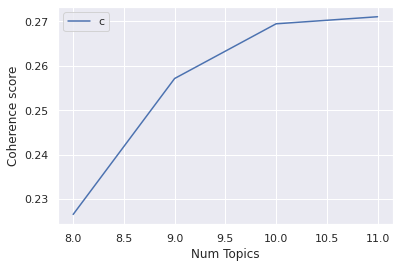

In [ ]:
sns.set()
limit=12; start=8; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_Lda)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=11, id2word=id2word, update_every=1, chunksize=100,  passes=10)


In [ ]:
coherencemodel = CoherenceModel(model=ldamodel, texts=filtered_words, dictionary=id2word, coherence='c_v')
coherence_values = coherencemodel.get_coherence()
print(coherence_values)

0.2530588316075251


In [ ]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=testdata):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=testdata)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(5)


In [ ]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7327,"war, georgia, president, south, ban, spy, thre...",A 117-year-old woman in Mexico City finally re...
1,1,8.0,0.5844,"crisis, law, bank, india, world, strike, claim...",IMF chief backs Athens as permanent Olympic host
2,2,6.0,0.5268,"russia, world, dead, protest, hit, want, food,...","The president of France says if Brexit won, so..."
3,3,8.0,0.5606,"crisis, law, bank, india, world, strike, claim...",British Man Who Must Give Police 24 Hours' Not...
4,4,9.0,0.3446,"new, woman, use, force, olympic, zimbabwe, mug...",100+ Nobel laureates urge Greenpeace to stop o...
...,...,...,...,...,...
73603,73603,6.0,0.4950,"russia, world, dead, protest, hit, want, food,...",Man goes berzerk in Akihabara and stabs everyo...
73604,73604,10.0,0.2614,"israeli, russian, palestinian, death, afghanis...",Threat of world AIDS pandemic among heterosexu...
73605,73605,10.0,0.3338,"israeli, russian, palestinian, death, afghanis...",Angst in Ankara: Turkey Steers into a Dangerou...
73606,73606,9.0,0.2406,"new, woman, use, force, olympic, zimbabwe, mug...",UK: Identity cards 'could be used to spy on pe...


In [ ]:
for idx,row in df_dominant_topic.iterrows():
  print( row['Document_No'], row['Keywords'].split(',')[:5]
        )


Streaming output truncated to the last 5000 lines.
68608 ['russia', ' world', ' dead', ' protest', ' hit']
68609 ['iraq', ' oil', ' year', ' plan', ' arrest']
68610 ['israeli', ' russian', ' palestinian', ' death', ' afghanistan']
68611 ['russia', ' world', ' dead', ' protest', ' hit']
68612 ['israeli', ' russian', ' palestinian', ' death', ' afghanistan']
68613 ['war', ' georgia', ' president', ' south', ' ban']
68614 ['iran', ' israel', ' gaza', ' ...', ' nuclear']
68615 ['leader', ' minister', ' peace', ' tell', ' admit']
68616 ['man', ' police', ' british', ' old', ' shoot']
68617 ['man', ' police', ' british', ' old', ' shoot']
68618 ['iran', ' israel', ' gaza', ' ...', ' nuclear']
68619 ['iraq', ' oil', ' year', ' plan', ' arrest']
68620 ['china', ' u.s.', ' bush', ' american', ' day']
68621 ['war', ' georgia', ' president', ' south', ' ban']
68622 ['israeli', ' russian', ' palestinian', ' death', ' afghanistan']
68623 ['crisis', ' law', ' bank', ' india', ' world']
68624 ['iraq'

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8990,"iraq, oil, year, plan, arrest, chinese, army, ...",Nigerian Army announces rescue of 5000 Boko Ha...
1,1.0,0.9174,"iran, israel, gaza, ..., nuclear, u.s., find, ...",Miners find 500-year-old shipwreck filled with...
2,2.0,0.8864,"china, u.s., bush, american, day, human, repor...",The Trans-Pacific Partnership Will Significant...
3,3.0,0.8485,"pakistan, kill, attack, military, child, bomb,...","In Baghdad, Sunnis await elections with unease '"
4,4.0,0.8990,"leader, minister, peace, tell, admit, hold, go...",Republic of Ireland fans to be awarded medal f...
5,5.0,0.9091,"man, police, british, old, shoot, court, right...",Hong Kong democracy activists call for return ...
6,6.0,0.9091,"russia, world, dead, protest, hit, want, food,...",Googles free wifi at Indian railway stations i...
7,7.0,0.8990,"war, georgia, president, south, ban, spy, thre...",Disrepair in South Ossetia Dims Hopes After Ge...
8,8.0,0.9091,"crisis, law, bank, india, world, strike, claim...","Four Months after Pluto Flyby, NASAs New Horiz..."
9,9.0,0.9301,"new, woman, use, force, olympic, zimbabwe, mug...",Cannabis compounds could treat Alzheimer's by ...


In [ ]:
for idx, row in sent_topics_sorted.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: iraq, oil, year, plan, arrest, chinese, army, north, korea, marriage

Nigerian Army announces rescue of 5000 Boko Haram hostages

Topic number 1
Keywords: iran, israel, gaza, ..., nuclear, u.s., find, official, iraqi, like

Miners find 500-year-old shipwreck filled with gold coins in Namibian desert

Topic number 2
Keywords: china, u.s., bush, american, day, human, report, torture, video, million

The Trans-Pacific Partnership Will Significantly Restrict Online Freedoms

Topic number 3
Keywords: pakistan, kill, attack, military, child, bomb, time, soldier, people, try

In Baghdad, Sunnis await elections with unease '

Topic number 4
Keywords: leader, minister, peace, tell, admit, hold, government, german, accuse, dangerous

Republic of Ireland fans to be awarded medal for sportsmanship by Paris mayor.

Topic number 5
Keywords: man, police, british, old, shoot, court, right, face, anti, identity

Hong Kong democracy activists call for return to British rule as f

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorted[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,0.0,"iraq, oil, year, plan, arrest, chinese, army, ...",7167,0.0974
1.0,1.0,"iran, israel, gaza, ..., nuclear, u.s., find, ...",5987,0.0813
2.0,2.0,"china, u.s., bush, american, day, human, repor...",5732,0.0779
3.0,3.0,"pakistan, kill, attack, military, child, bomb,...",5899,0.0801
4.0,4.0,"leader, minister, peace, tell, admit, hold, go...",6653,0.0904
5.0,5.0,"man, police, british, old, shoot, court, right...",8386,0.1139
6.0,6.0,"russia, world, dead, protest, hit, want, food,...",6670,0.0906
7.0,7.0,"war, georgia, president, south, ban, spy, thre...",6388,0.0868
8.0,8.0,"crisis, law, bank, india, world, strike, claim...",7741,0.1052
9.0,9.0,"new, woman, use, force, olympic, zimbabwe, mug...",6908,0.0938


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,0.0,"iraq, oil, year, plan, arrest, chinese, army, north, korea, marriage",7167,0.0974
1.0,1.0,"iran, israel, gaza, ..., nuclear, u.s., find, official, iraqi, like",5987,0.0813
2.0,2.0,"china, u.s., bush, american, day, human, report, torture, video, million",5732,0.0779
3.0,3.0,"pakistan, kill, attack, military, child, bomb, time, soldier, people, try",5899,0.0801
4.0,4.0,"leader, minister, peace, tell, admit, hold, government, german, accuse, dangerous",6653,0.0904
5.0,5.0,"man, police, british, old, shoot, court, right, face, anti, identity",8386,0.1139
6.0,6.0,"russia, world, dead, protest, hit, want, food, end, little, terror",6670,0.0906
7.0,7.0,"war, georgia, president, south, ban, spy, threat, die, drug, city",6388,0.0868
8.0,8.0,"crisis, law, bank, india, world, strike, claim, fire, new, missile",7741,0.1052
9.0,9.0,"new, woman, use, force, olympic, zimbabwe, mugabe, help, criminal, security",6908,0.0938


In [ ]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)


In [ ]:
for top in ldamodel.print_topics():
  print(top)

(0, '0.040*"iraq" + 0.021*"oil" + 0.019*"year" + 0.018*"plan" + 0.017*"arrest" + 0.014*"chinese" + 0.012*"army" + 0.012*"north" + 0.012*"korea" + 0.010*"marriage"')
(1, '0.067*"iran" + 0.066*"israel" + 0.034*"gaza" + 0.032*"..." + 0.029*"nuclear" + 0.025*"u.s." + 0.023*"find" + 0.019*"official" + 0.016*"iraqi" + 0.014*"like"')
(2, '0.043*"china" + 0.033*"u.s." + 0.023*"bush" + 0.019*"american" + 0.019*"day" + 0.016*"human" + 0.015*"report" + 0.014*"torture" + 0.013*"video" + 0.013*"million"')
(3, '0.038*"pakistan" + 0.037*"kill" + 0.035*"attack" + 0.032*"military" + 0.031*"child" + 0.019*"bomb" + 0.018*"time" + 0.016*"soldier" + 0.014*"people" + 0.013*"try"')
(4, '0.021*"leader" + 0.017*"minister" + 0.016*"peace" + 0.016*"tell" + 0.016*"admit" + 0.013*"hold" + 0.013*"government" + 0.011*"german" + 0.011*"accuse" + 0.011*"dangerous"')
(5, '0.039*"man" + 0.028*"police" + 0.022*"british" + 0.019*"old" + 0.014*"shoot" + 0.013*"court" + 0.013*"right" + 0.012*"face" + 0.012*"anti" + 0.011*"i

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.230443 -0.060203       1        1  10.927745
5     -0.109234  0.140615       2        1  10.704714
9      0.152578 -0.160677       3        1  10.141280
0      0.038580 -0.036876       4        1   9.509395
6      0.160105  0.076280       5        1   9.319925
2     -0.236298 -0.127963       6        1   8.930645
3      0.000742  0.254609       7        1   8.269494
1     -0.202631 -0.122131       8        1   8.236963
7     -0.025357 -0.027857       9        1   8.152569
4      0.033737 -0.133265      10        1   8.047993
10    -0.042665  0.197467      11        1   7.759276, topic_info=               Term         Freq        Total Category  logprob  loglift
150            iran  4426.000000  4426.000000  Default  30.0000  30.0000
1941         israel  4358.000000  4358.000000  Default  29.0000  29.0000
215             war  4282.000000  4282.000000  Default  28.0000  28.0000
139         israeli  3850.000000  3850.000000  Default  27.0000  27.0000
415          russia  3638.000000  3638.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
16171  heterosexual   383.878264   385.153612  Topic11  -5.0808   2.5530
927        genocide   328.998682   330.162754  Topic11  -5.2350   2.5527
1419         moscow   327.635666   328.799744  Topic11  -5.2392   2.5527
32523       qinghai   380.256508   385.253204  Topic11  -5.0902   2.5432
105            kill  1066.638685  3500.731122  Topic11  -4.0588   1.3678

[404 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
900        8  0.999654       ...
4694       1  0.997486      2008
13045      2  0.002295       5.1
13045      5  0.993859       5.1
13045     10  0.002295       5.1
...      ...       ...       ...
19         4  0.412565      year
19         5  0.219530      year
19         7  0.168578      year
1090       4  0.997928     young
1725       3  0.998820  zimbabwe

[406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 1, 7, 3, 4, 2, 8, 5, 11])

In [ ]:
#Function to generate the word cloud 
def create_word_cloud(string):
  cloud = WordCloud(background_color = "white", max_words = 200)
  cloud.generate(string)
  plt.imshow(cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
def convertListToString(s):  
  str1 = "  "  
  for ele in s:  
    str1 += ele + ' ' 
  return str1  

In [ ]:
def Extract(lst): 
    return [item[0] for item in lst] 

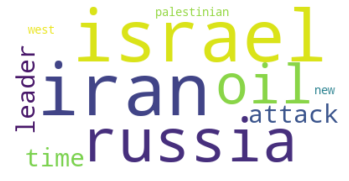

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(0))))

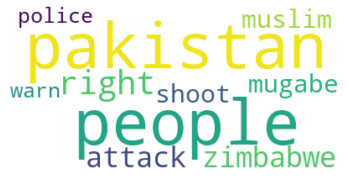

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(1))))

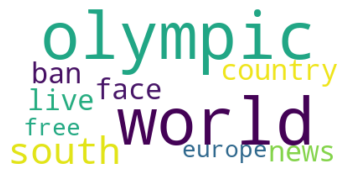

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(2))))

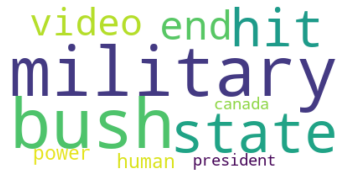

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(3))))

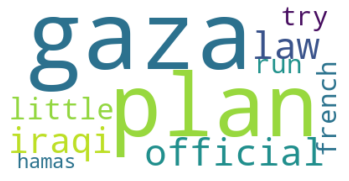

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(4))))

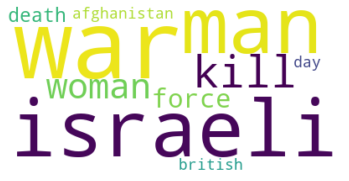

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(5))))

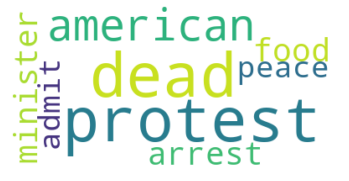

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(6))))

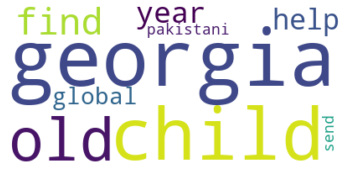

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(7))))

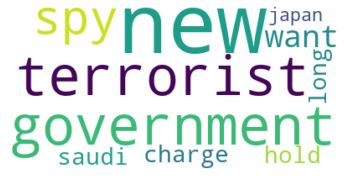

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(8))))

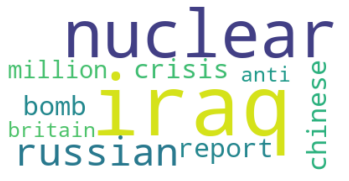

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(9))))

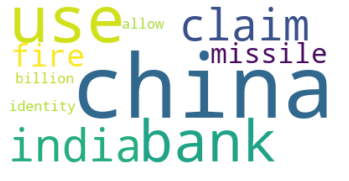

In [ ]:
create_word_cloud(convertListToString(Extract(ldamodel.show_topic(10))))